In [1]:
#pip install seaborn

In [2]:
#pip install --upgrade pip

In [4]:
import re
import string
import nltk
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential

import seaborn as sns

# Load pre-existing dataset
# Assume X and y are loaded from the dataset

# Download NLTK resources if not already downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')









[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\saich\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saich\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\saich\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\saich\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [5]:
def load_and_pre_clean_csv_data(csv_file_path):
    """ load the csv file data and preprocess it by removing row with any emptry column 
        or rows with any invalid data for the particular column"""
    # Load CSV data into DataFrame
    df = pd.read_csv(csv_file_path)
    df
    # Remove rows where the "text" column is empty
    df = df.dropna(subset=['text'])

    # Remove rows where the "target" column is non-numeric
    df = df[pd.to_numeric(df['target'], errors='coerce').notna()]

    # Convert "target" column to numeric type
    df['target'] = pd.to_numeric(df['target'])

    # Optional: Reset index after filtering
    df.reset_index(drop=True, inplace=True)

    return df

In [6]:
def preprocess_tweet(tweet):
    """
    Preprocess a single tweet.
    """
    # Remove links
    tweet = re.sub(r'http\S+', '', tweet)

    # Remove emojis
    tweet = tweet.encode('ascii', 'ignore').decode('ascii')

    # Remove punctuation
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    
    # Convert to lowercase
    tweet = tweet.lower()
    return tweet

In [7]:
def tokenize_and_clean(tweet):
    """
    Tokenize, remove stopwords, and lemmatize a single tweet.
    """
    # Tokenize
    tokens = word_tokenize(tweet)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens



In [10]:
def pad_vectors(dt):
    """
        padd the rows and columns of the matrix of the vectors
    """
    width = 100
    height = 20
    for index,i  in enumerate(dt):
        diff = width - len(i)
        if diff > 0:
            dt[index] = np.append(dt[index], [0] * diff)
    
    if height > len(dt):
        dt.append([0] * width)

    
    return dt




In [11]:
# Load data from CSV file
FILE_NAME = './tweets.csv'
data = load_and_pre_clean_csv_data(FILE_NAME)
data = data.drop(columns = 'keyword', axis = 'columns')
data

,id,location,text,target
0,0,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,NaN,"""Lord Jesus, your love brings freedom and pard...",0
...,...,...,...,...
11365,11365,Blue State in a red sea,Media should have warned us well in advance. T...,0
11366,11366,arohaonces,i feel directly attacked 💀 i consider moonbin ...,0
11367,11367,🇵🇭,i feel directly attacked 💀 i consider moonbin ...,0
11368,11368,auroraborealis,"ok who remember ""outcast"" nd the ""dora"" au?? T...",0


In [12]:
#pip install plotly.express

target
0    9256
1    2114
Name: count, dtype: int64


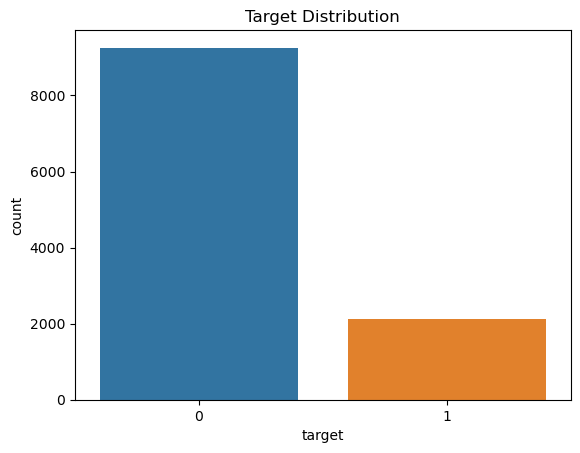

In [13]:
sns.countplot(x='target', data=data,)
plt.title('Target Distribution');

print(data['target'].value_counts())

In [14]:
# Preprocess the 'text' column
data['preprocessed_text'] = data['text'].apply(preprocess_tweet)


In [15]:
# Creating a new feature for the visualization.

data['Character Count'] = data['preprocessed_text'].apply(lambda x: len(str(x)))
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
def plot_dist3(df, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='violet')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    # Plotting the ecdf_Plot.
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#2846CD')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    # Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    ax3.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(x=feature, data=df, orient='v', ax=ax3, color='grey')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=25))

    plt.suptitle(f'{title}', fontsize=24)

C:\Users\saich\AppData\Local\Temp\ipykernel_14188\186120180.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[:, feature],
C:\Users\saich\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\saich\AppData\Local\Temp\ipykernel_14188\186120180.py:30: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexi

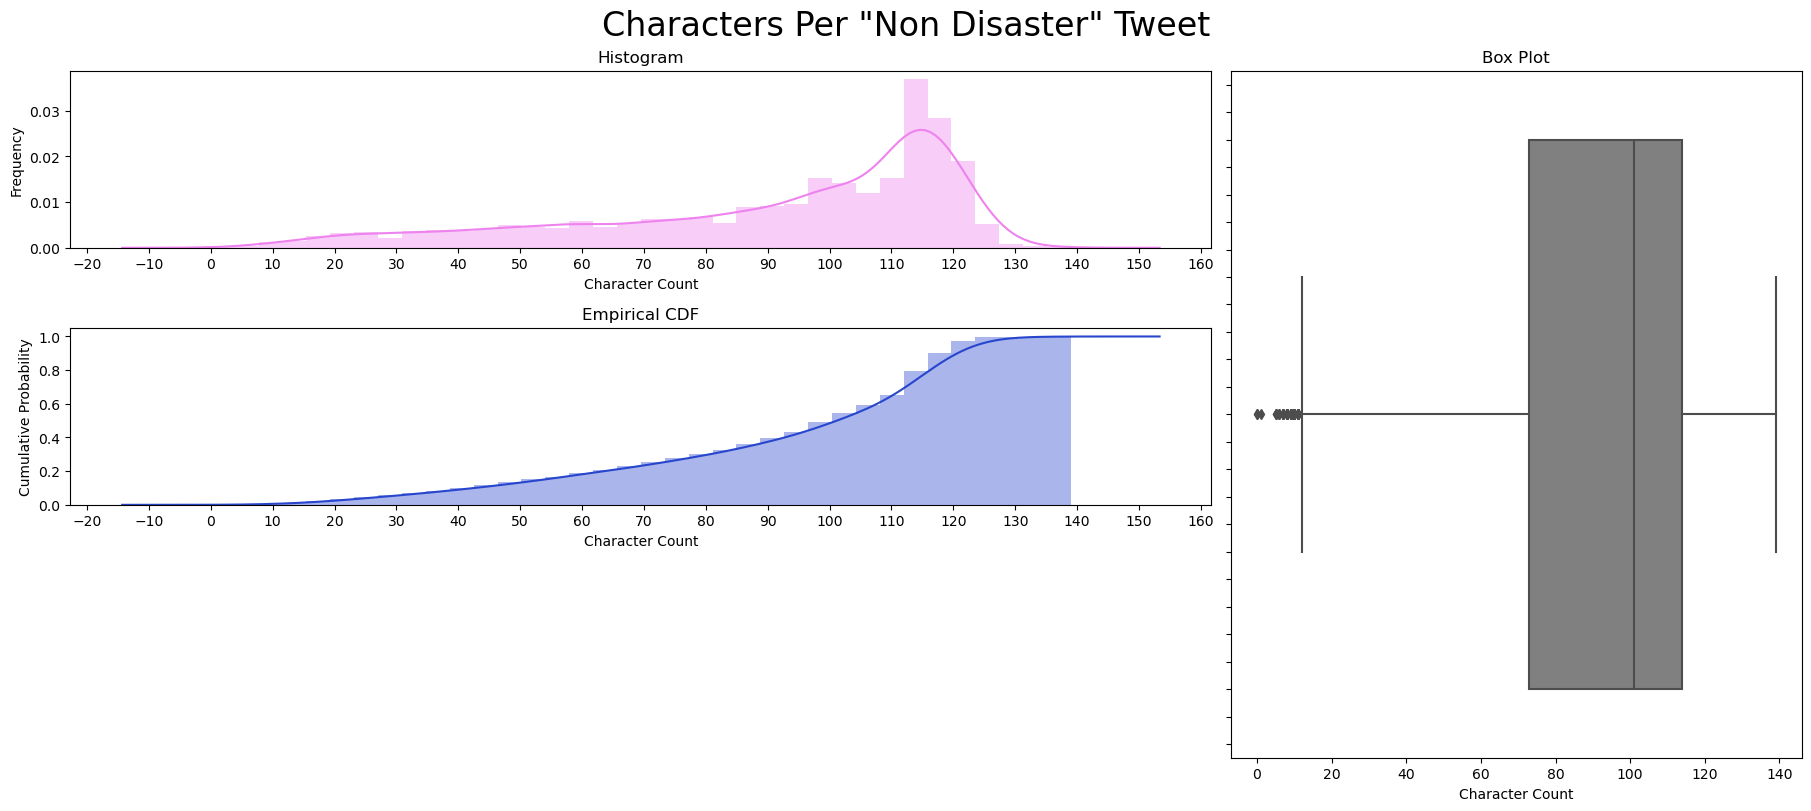

In [16]:
plot_dist3(data[data['target'] == 0], 'Character Count',
           'Characters Per "Non Disaster" Tweet')

C:\Users\saich\AppData\Local\Temp\ipykernel_14188\186120180.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[:, feature],
C:\Users\saich\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\saich\AppData\Local\Temp\ipykernel_14188\186120180.py:30: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexi

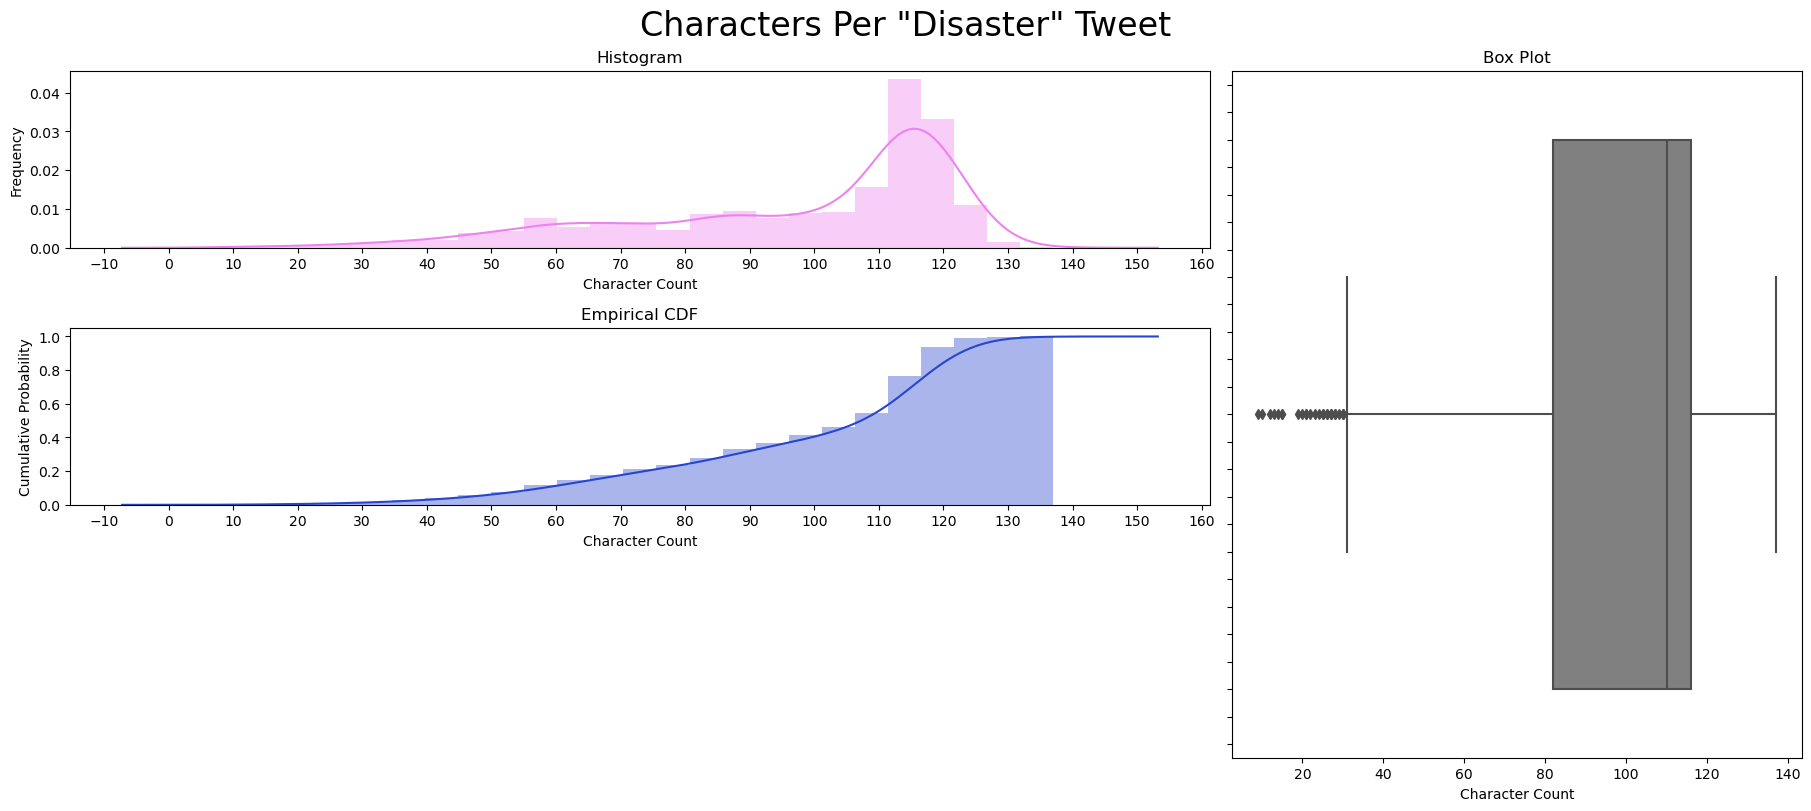

In [17]:
plot_dist3(data[data['target'] == 1], 'Character Count',
           'Characters Per "Disaster" Tweet')

In [18]:
def plot_word_number_histogram(textno, textye):
    
    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().map(lambda x: len(x)), ax=axes[1], color='#e74c3c')
    
    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Non Disaster Tweets')
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('Disaster Tweets')
    
    fig.suptitle('Words Per Tweet', fontsize=24, va='baseline')
    
    fig.tight_layout()

C:\Users\saich\AppData\Local\Temp\ipykernel_14188\1585757681.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c')
C:\Users\saich\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\saich\AppData\Local\Temp\ipykernel_14188\1585757681.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `d

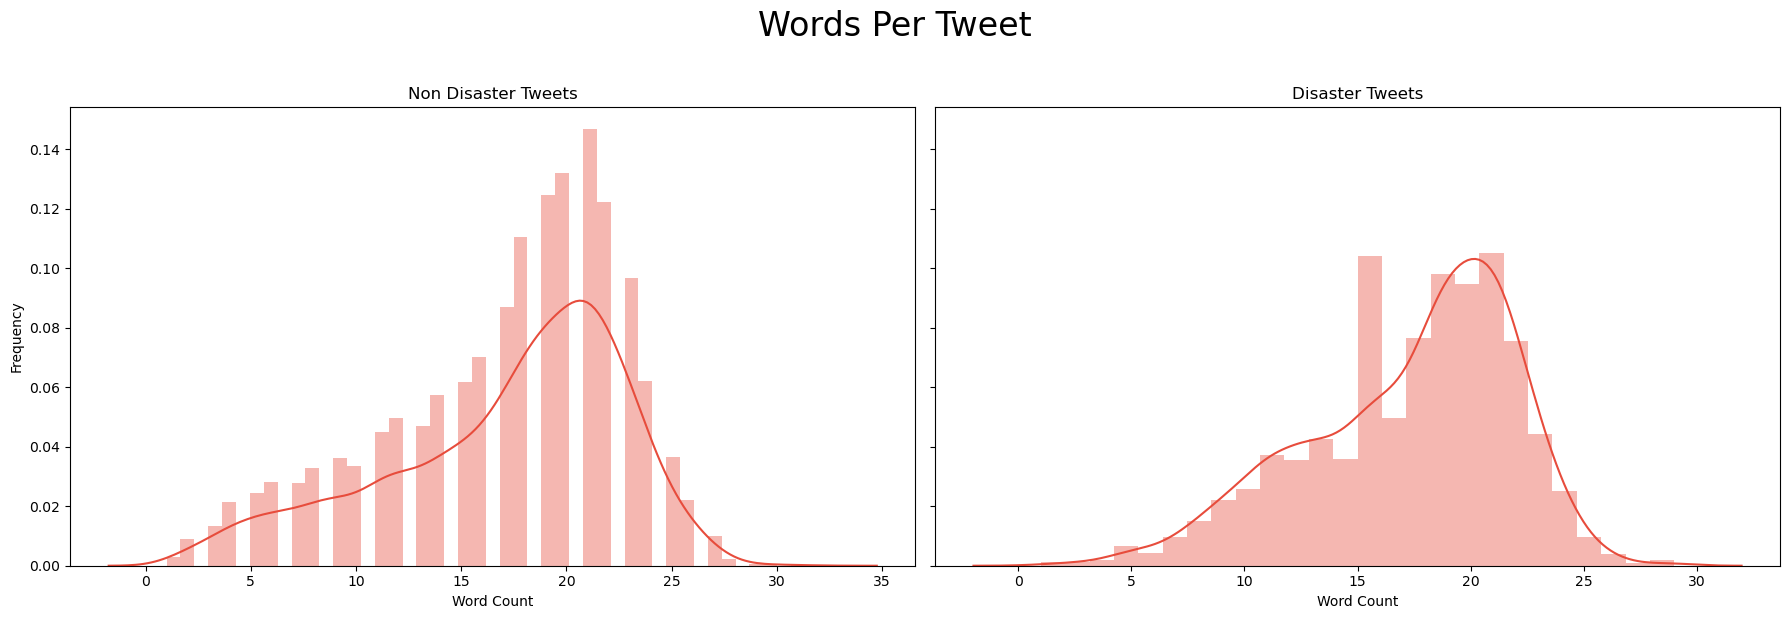

In [19]:
plot_word_number_histogram(data[data['target'] == 0]['text'],
                           data[data['target'] == 1]['text'])

In [20]:
# Tokenize, remove stopwords, and lemmatize each tweet
data['tokenized_text'] = data['preprocessed_text'].apply(tokenize_and_clean)

# remove rows where column "tokenized_text" is empty
data = data[data['tokenized_text'].apply(len) > 0]

# Display the first few rows of the preprocessed and tokenized data
data.head(20)

,id,location,text,target,preprocessed_text,Character Count,tokenized_text
0,0,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1,communal violence in bhainsa telangana stones ...,120,"[communal, violence, bhainsa, telangana, stone..."
1,1,NaN,Telangana: Section 144 has been imposed in Bha...,1,telangana section 144 has been imposed in bhai...,127,"[telangana, section, 144, imposed, bhainsa, ja..."
2,2,New York City,Arsonist sets cars ablaze at dealership https:...,1,arsonist sets cars ablaze at dealership,40,"[arsonist, set, car, ablaze, dealership]"
3,3,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1,arsonist sets cars ablaze at dealership,41,"[arsonist, set, car, ablaze, dealership]"
4,4,NaN,"""Lord Jesus, your love brings freedom and pard...",0,lord jesus your love brings freedom and pardon...,113,"[lord, jesus, love, brings, freedom, pardon, f..."
5,5,OC,"If this child was Chinese, this tweet would ha...",0,if this child was chinese this tweet would hav...,118,"[child, chinese, tweet, would, gone, viral, so..."
6,6,"London, England",Several houses have been set ablaze in Ngemsib...,1,several houses have been set ablaze in ngemsib...,114,"[several, house, set, ablaze, ngemsibaa, villa..."
7,7,Bharat,Asansol: A BJP office in Salanpur village was ...,1,asansol a bjp office in salanpur village was s...,127,"[asansol, bjp, office, salanpur, village, set,..."
8,8,"Accra, Ghana","National Security Minister, Kan Dapaah's side ...",0,national security minister kan dapaahs side ch...,108,"[national, security, minister, kan, dapaahs, s..."
9,9,Searching,This creature who’s soul is no longer clarent ...,0,this creature whos soul is no longer clarent b...,102,"[creature, who, soul, longer, clarent, blue, a..."


In [21]:
# vectorize tweets
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['preprocessed_text'])
y = data['target']

data['lemma_str'] = [' '.join(map(str, l)) for l in data['tokenized_text']]
# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\n\n\n")



C:\Users\saich\AppData\Local\Temp\ipykernel_14188\1445020277.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['lemma_str'] = [' '.join(map(str, l)) for l in data['tokenized_text']]


In [22]:
def oversampling_minority(vectorized_x, y):
    from imblearn.over_sampling import RandomOverSampler
    from sklearn.feature_extraction.text import CountVectorizer
    import pandas as pd

#     X_class_1 = data['preprocessed_text']
#     y_class_1 = data['target']

#     vectorizer = CountVectorizer()
#     X_count_class_1 = vectorizer.fit_transform(X_class_1)

    oversampler = RandomOverSampler(sampling_strategy='minority')
    X_resampled_class_1, y_resampled_class_1 = oversampler.fit_resample(vectorized_x, y)
#     print(y_resampled_class_1.value_counts())
    
    return X_resampled_class_1, y_resampled_class_1

In [23]:
X, y = oversampling_minority(X, y)

In [24]:
demo = X.toarray()
len(demo)

18498

In [52]:
 from collections import Counter
list_counts = Counter(map(tuple, demo))

# Find duplicate lists
duplicate_lists = [list(elem) for elem, count in list_counts.items() if count > 1]

# Print duplicate lists
print("Duplicate Lists:", duplicate_lists) 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[9249 9249]


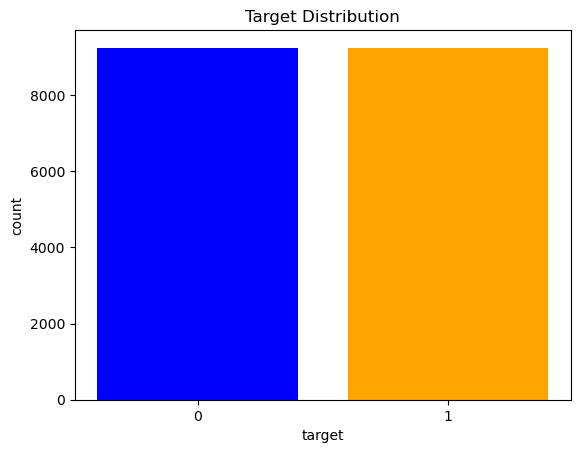

In [26]:
counts = np.bincount(y)
print(counts)
# Plotting the counts
labels = ['0', '1']
plt.bar(labels, counts[:2], color=['blue', 'orange'])
plt.xlabel('target')
plt.ylabel('count')
plt.title('Target Distribution')
plt.show()

In [27]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46, stratify = y)

# Check the class ratio in training and testing sets
train_class_ratio = np.bincount(y_train)
test_class_ratio = np.bincount(y_test)
train_class_ratio

array([7399, 7399], dtype=int64)

C:\Users\saich\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\saich\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


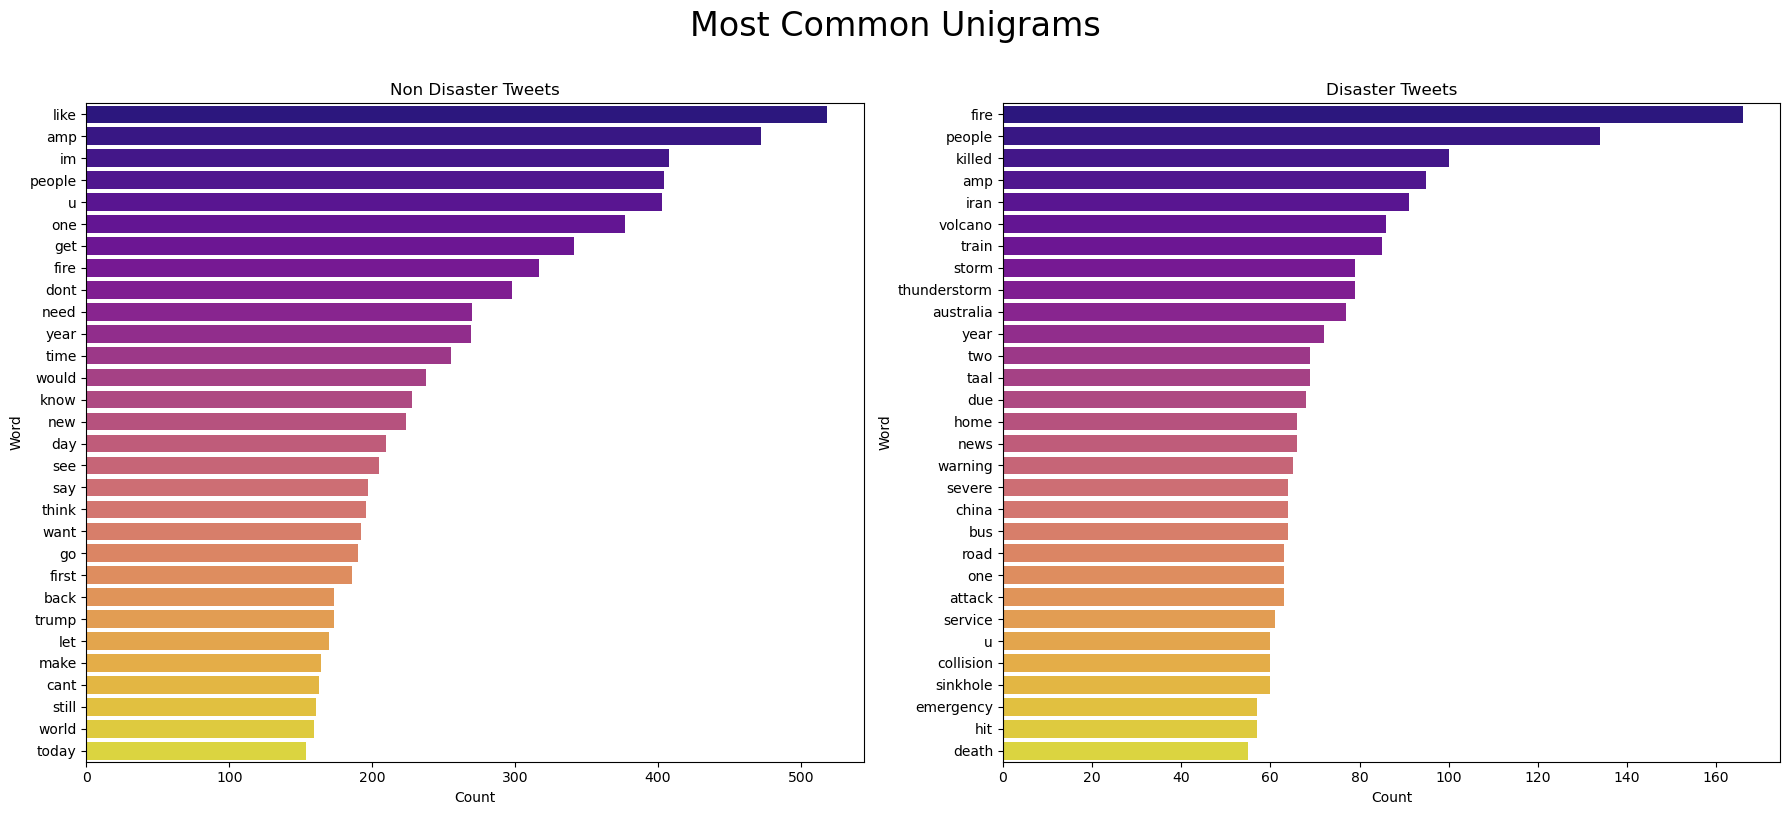

In [29]:
from collections import Counter
stop_words = set(stopwords.words('english'))
lis = [
    data[data['target'] == 0]['lemma_str'],
    data[data['target'] == 1]['lemma_str']
]
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):

    new = i.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        if (word not in stop_words):
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, palette='plasma', ax=j)
axes[0].set_title('Non Disaster Tweets')

axes[1].set_title('Disaster Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')

fig.suptitle('Most Common Unigrams', fontsize=24, va='baseline')
plt.tight_layout()

In [30]:
def ngrams(n, title):
    """A Function to plot most common ngrams"""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    axes = axes.flatten()
    for i, j in zip(lis, axes):

        new = i.str.split()
        new = new.values.tolist()
        corpus = [word for i in new for word in i]

        def _get_top_ngram(corpus, n=None):
            #getting top ngrams
            vec = CountVectorizer(ngram_range=(n, n),
                                  max_df=0.9,
                                  stop_words='english').fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx])
                          for word, idx in vec.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            return words_freq[:15]

        top_n_bigrams = _get_top_ngram(i, n)[:15]
        x, y = map(list, zip(*top_n_bigrams))
        sns.barplot(x=y, y=x, palette='plasma', ax=j)
        
        axes[0].set_title('Non Disaster Tweets')
        axes[1].set_title('Disaster Tweets')
        axes[0].set_xlabel('Count')
        axes[0].set_ylabel('Words')
        axes[1].set_xlabel('Count')
        axes[1].set_ylabel('Words')
        fig.suptitle(title, fontsize=24, va='baseline')
        plt.tight_layout()

C:\Users\saich\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\saich\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


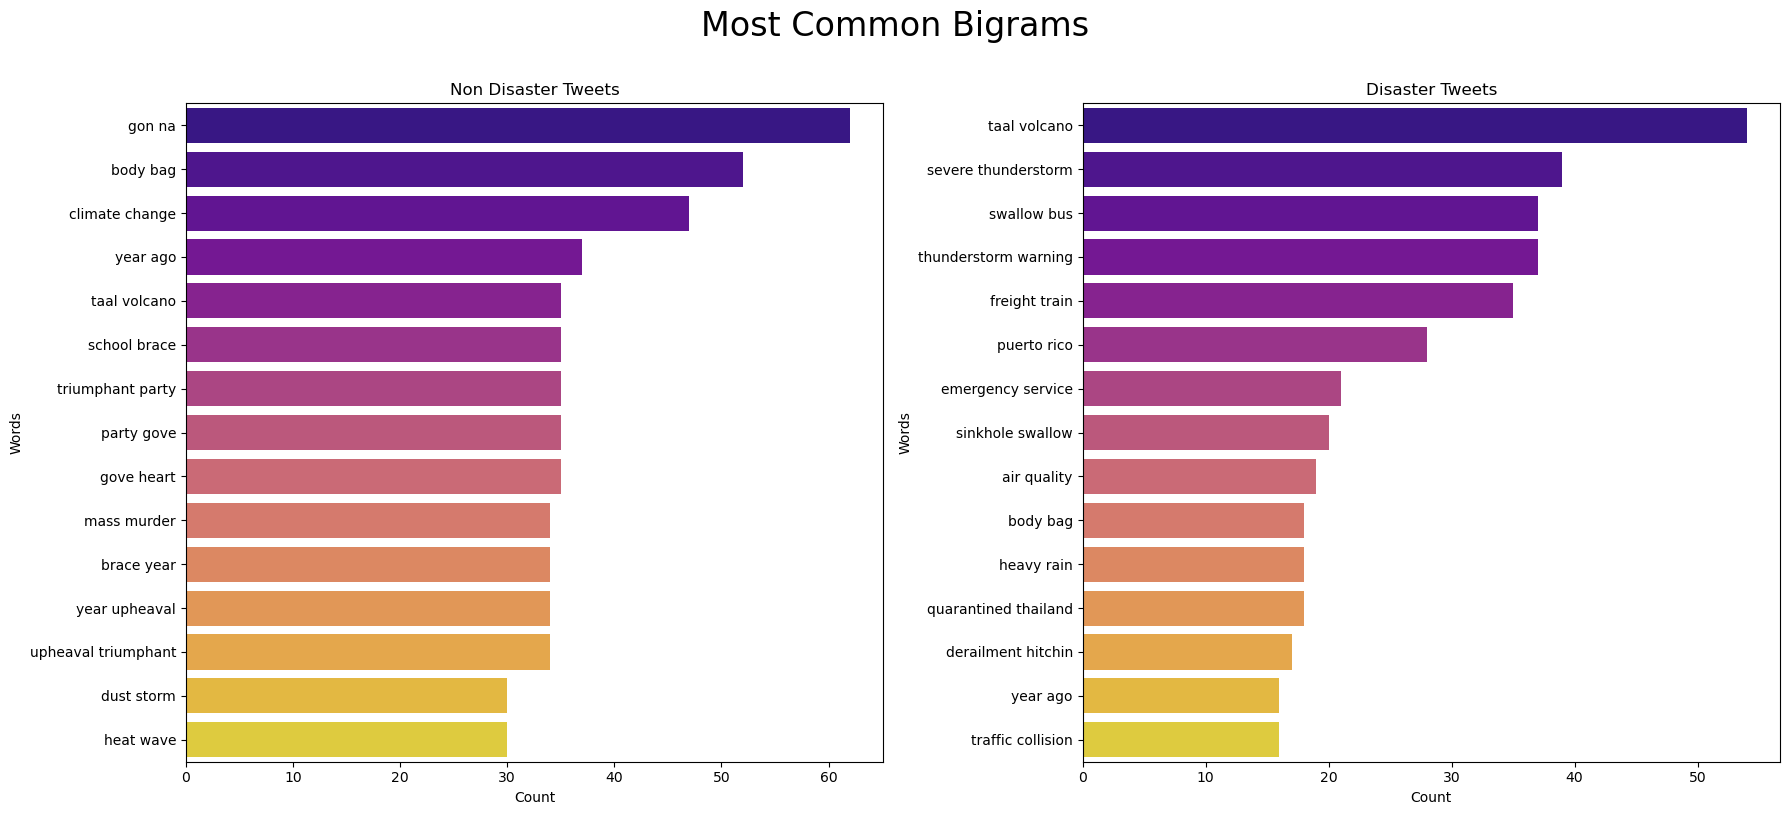

In [31]:
ngrams(2, 'Most Common Bigrams')


C:\Users\saich\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\saich\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


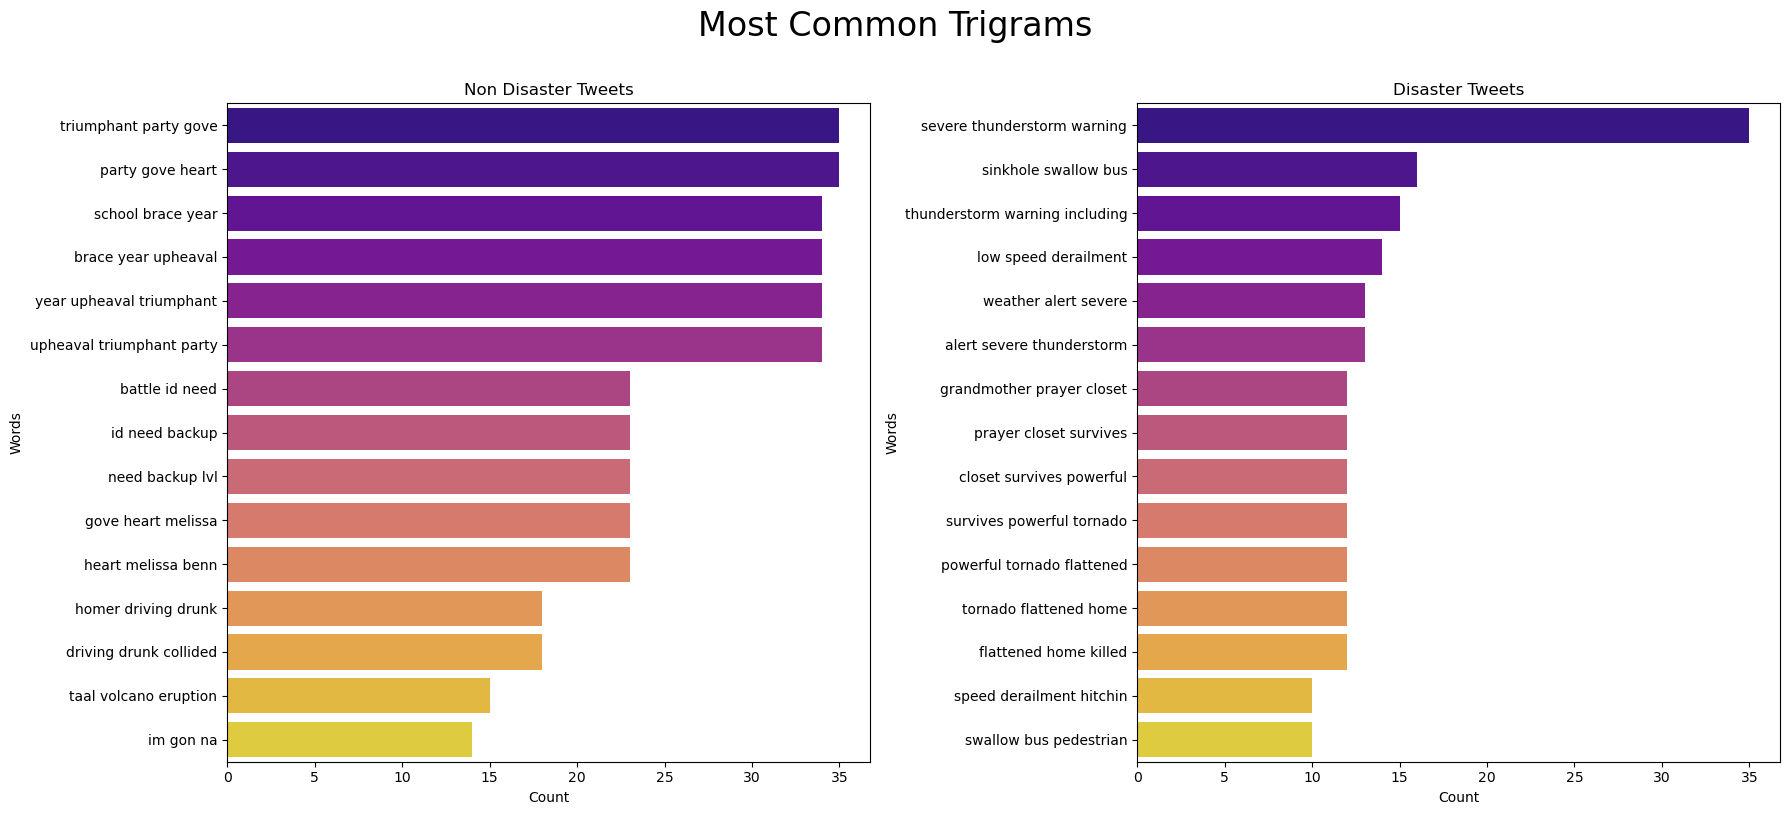

In [32]:
ngrams(3, 'Most Common Trigrams')


In [33]:
''' # word cloud of disaster and non-disaster tweets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 5])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(data[data['target'] ==1 ]['text']))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(data[data['target'] ==0 ]['text']))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40); '''

' # word cloud of disaster and non-disaster tweets\nfig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 5])\nwordcloud1 = WordCloud( background_color=\'white\',\n                        width=600,\n                        height=400).generate(" ".join(data[data[\'target\'] ==1 ][\'text\']))\nax1.imshow(wordcloud1)\nax1.axis(\'off\')\nax1.set_title(\'Disaster Tweets\',fontsize=40);\n\nwordcloud2 = WordCloud( background_color=\'white\',\n                        width=600,\n                        height=400).generate(" ".join(data[data[\'target\'] ==0 ][\'text\']))\nax2.imshow(wordcloud2)\nax2.axis(\'off\')\nax2.set_title(\'Non Disaster Tweets\',fontsize=40); '

In [34]:
data.head()

,id,location,text,target,preprocessed_text,Character Count,tokenized_text,lemma_str
0,0,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1,communal violence in bhainsa telangana stones ...,120,"[communal, violence, bhainsa, telangana, stone...",communal violence bhainsa telangana stone pelt...
1,1,NaN,Telangana: Section 144 has been imposed in Bha...,1,telangana section 144 has been imposed in bhai...,127,"[telangana, section, 144, imposed, bhainsa, ja...",telangana section 144 imposed bhainsa january ...
2,2,New York City,Arsonist sets cars ablaze at dealership https:...,1,arsonist sets cars ablaze at dealership,40,"[arsonist, set, car, ablaze, dealership]",arsonist set car ablaze dealership
3,3,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1,arsonist sets cars ablaze at dealership,41,"[arsonist, set, car, ablaze, dealership]",arsonist set car ablaze dealership
4,4,NaN,"""Lord Jesus, your love brings freedom and pard...",0,lord jesus your love brings freedom and pardon...,113,"[lord, jesus, love, brings, freedom, pardon, f...",lord jesus love brings freedom pardon fill hol...


In [35]:
#pip install xgboost

In [36]:
# Supervised Learning Models
from xgboost import XGBClassifier

print("Supervised Learning Models".upper())
models = {
    'Logistic Regression': LogisticRegression(penalty='l2', dual = False),
    'Decision Tree': DecisionTreeClassifier(criterion = 'log_loss'),
    
    'Gradient Boosting': GradientBoostingClassifier(),
    'Support Vector Machine': SVC(kernel='rbf'),
    'xgb' : XGBClassifier()
}

evals = {}
accs = {}
prec = {}
rec = {}
f1 = {}


for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test,y_pred)
    f1score = f1_score(y_test, y_pred)
    
    accs[name] = accuracy
    prec[name] = precision
    rec[name] = recall
    f1[name] = f1score
    
    evals[name] = [accuracy, precision, recall, f1score]
    
    print(f"\n{name}\n".upper())
    print(f"{name} Accuracy: {accuracy}")
    print(f"{name} Precision: {precision}")
    print(f"{name} Recall: {recall}")
    print(f"{name} F1score: {f1score}")
    
#     cm = confusion_matrix(y_test, y_pred)

# # Plotting the confusion matrix
#     plt.figure(figsize=(4, 4))
#     sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

# # Add labels and title
#     plt.xlabel('Predicted Labels')
#     plt.ylabel('True Labels')
#     plt.title('Confusion Matrix')

# # Show the plot
#     plt.show()


    print("\n ----------------------------------- \n")



SUPERVISED LEARNING MODELS


C:\Users\saich\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



LOGISTIC REGRESSION

Logistic Regression Accuracy: 0.9532432432432433
Logistic Regression Precision: 0.9315491507977355
Logistic Regression Recall: 0.9783783783783784
Logistic Regression F1score: 0.9543896651726866

 ----------------------------------- 


DECISION TREE

Decision Tree Accuracy: 0.9413513513513514
Decision Tree Precision: 0.9032098765432098
Decision Tree Recall: 0.9886486486486487
Decision Tree F1score: 0.944

 ----------------------------------- 


GRADIENT BOOSTING

Gradient Boosting Accuracy: 0.7681081081081081
Gradient Boosting Precision: 0.7860438292964245
Gradient Boosting Recall: 0.7367567567567568
Gradient Boosting F1score: 0.7606026785714286

 ----------------------------------- 


SUPPORT VECTOR MACHINE

Support Vector Machine Accuracy: 0.9708108108108108
Support Vector Machine Precision: 0.971830985915493
Support Vector Machine Recall: 0.9697297297297297
Support Vector Machine F1score: 0.9707792207792209

 ----------------------------------- 


XGB

xgb Accur

In [37]:
evals

{'Logistic Regression': [0.9532432432432433,
  0.9315491507977355,
  0.9783783783783784,
  0.9543896651726866],
 'Decision Tree': [0.9413513513513514,
  0.9032098765432098,
  0.9886486486486487,
  0.944],
 'Gradient Boosting': [0.7681081081081081,
  0.7860438292964245,
  0.7367567567567568,
  0.7606026785714286],
 'Support Vector Machine': [0.9708108108108108,
  0.971830985915493,
  0.9697297297297297,
  0.9707792207792209],
 'xgb': [0.8827027027027027,
  0.8839479392624728,
  0.8810810810810811,
  0.8825121819166215]}

In [56]:
xaxis = list(accs.keys())
# xaxis.remove("randomforest")
yaxis = list(accs.values())
yaxis
xaxis

['Logistic Regression',
 'Decision Tree',
 'Gradient Boosting',
 'Support Vector Machine',
 'xgb']

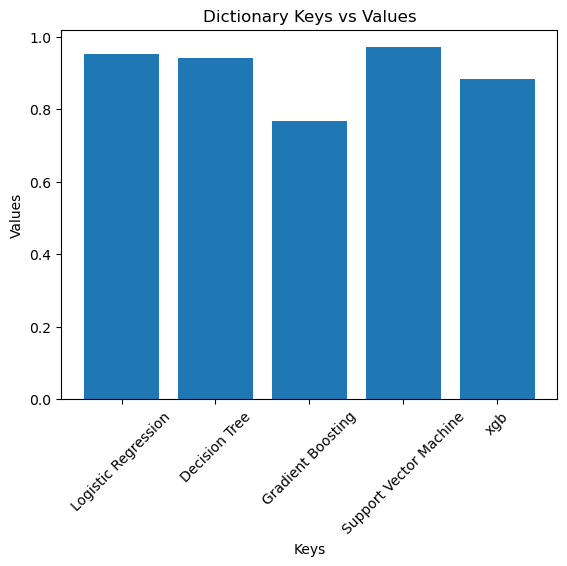

In [39]:
plt.bar(xaxis, yaxis)

# Adding labels and title
plt.xlabel('Keys')
plt.ylabel('Values')
plt.title('Dictionary Keys vs Values')

# Rotating x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [46]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=0.01)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test,y_pred)
f1score = f1_score(y_test, y_pred)

print(accuracy)
print(precision)
print(recall)
print(f1score)

0.607027027027027
0.6739894551845342
0.4145945945945946
0.5133868808567604


In [41]:
# Deep Learning Models
print("Deep Learning Models".upper())
X_train = X_train.toarray()
X_test = X_test.toarray()

VOCAB_SIZE =10000
EMBEDDING_DIM = 16

model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(5),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)

print("Loss: ", loss)
print("Accuracy: ", accuracy)
print("\n\n\n")






DEEP LEARNING MODELS
Epoch 1/10
463/463 [==============================] - 362s 776ms/step - loss: 0.6935 - accuracy: 0.4944 - val_loss: 0.6925 - val_accuracy: 0.5322
Epoch 2/10
463/463 [==============================] - 363s 784ms/step - loss: 0.6869 - accuracy: 0.5335 - val_loss: 0.6863 - val_accuracy: 0.5446
Epoch 3/10
463/463 [==============================] - 353s 762ms/step - loss: 0.6856 - accuracy: 0.5451 - val_loss: 0.6852 - val_accuracy: 0.5435
Epoch 4/10
463/463 [==============================] - 353s 763ms/step - loss: 0.6843 - accuracy: 0.5419 - val_loss: 0.6871 - val_accuracy: 0.5454
Epoch 5/10
463/463 [==============================] - 354s 764ms/step - loss: 0.6844 - accuracy: 0.5447 - val_loss: 0.6856 - val_accuracy: 0.5449
Epoch 6/10
463/463 [==============================] - 358s 772ms/step - loss: 0.6845 - accuracy: 0.5429 - val_loss: 0.6852 - val_accuracy: 0.5449
Epoch 7/10
463/463 [==============================] - 358s 774ms/step - loss: 0.6836 - accuracy: 0.5489

In [64]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='base_cnn_model.png')
model.summary()

AttributeError: 'AdaBoostClassifier' object has no attribute 'summary'

In [42]:
# Ensemble Method (Voting Classifier)
print("Ensemble Method (Voting Classifier)".upper())
estimators = list(models.items())
voting_classifier = VotingClassifier(estimators)
voting_classifier.fit(X_train, y_train)
y_pred = voting_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Voting Classifier Accuracy: {accuracy}")

ENSEMBLE METHOD (VOTING CLASSIFIER)


C:\Users\saich\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting Classifier Accuracy: 0.9589189189189189


In [43]:
randomForestModel = RandomForestClassifier(n_estimators = 50, criterion = 'log_loss')
randomForestModel.fit(X_train, y_train)
y_pred = randomForestModel.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test,y_pred)
f1score = f1_score(y_test, y_pred)

accs['randomforest'] = accuracy
prec['randomforest'] = precision
rec['randomforest'] = recall
f1['randomforest'] = f1score
evals['randomforest'] = [accuracy, precision, recall, f1score]

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1score: {f1score}")
print("\n ----------------------------------- \n")

Accuracy: 0.9829729729729729
Precision: 0.9785752544188537
Recall: 0.9875675675675676
F1score: 0.9830508474576272

 ----------------------------------- 



[0.9562162162162162,
 0.9483783783783784,
 0.7645945945945946,
 0.9737837837837838,
 0.8718918918918919]

['Logistic Regression', 'Decision Tree', 'Gradient Boosting', 'Support Vector Machine', 'xgb']


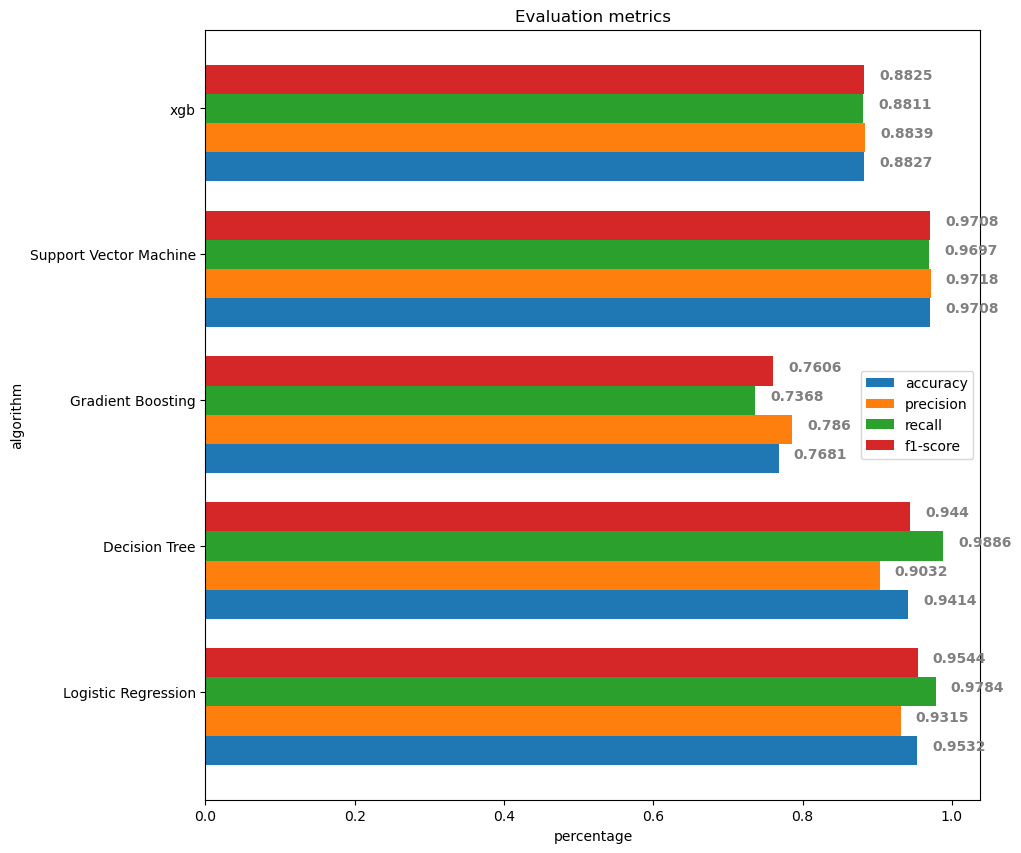

In [61]:
# xaxis.remove("randomforest")
print(xaxis)
X_axis = np.arange(len(xaxis)) 

fig, ax = plt.subplots(figsize =(10, 10))

acc_x_values = [v for k, v in accs.items() if k != "randomforest"]
prec_x_values = [v for k, v in prec.items() if k != "randomforest"]
rec_x_values = [v for k, v in rec.items() if k != "randomforest"]
f1_x_values = [v for k, v in f1.items() if k != "randomforest"]
# plt.figure(figsize = (15,6))
ax.barh(X_axis-0.4, acc_x_values, 0.2, label = 'accuracy') 
ax.barh(X_axis-0.2, prec_x_values, 0.2, label = 'precision')
ax.barh(X_axis, rec_x_values, 0.2, label = 'recall')
ax.barh(X_axis+0.2, f1_x_values, 0.2, label = 'f1-score')

# values = list(evals.values())
# num_metrics = len(values[0])
# # values[0]
# for i, key in enumerate(evals):
#     bars = ax.bar(num_metrics + i * 0.03, evals[key], width=0.01, label=key)
    
  
# # for i, key in enumerate(accs):
# #     bars = ax.bar(x_positions + i * bar_width, values[i], width=bar_width, label=key)
# #     for bar in bars:
# #         yval = bar.get_height()
# #         ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

for i in ax.patches:
    plt.text(i.get_width()+0.02, i.get_y()+0.1, 
             str(round((i.get_width()), 4)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

plt.yticks(X_axis, xaxis) 
# ax.set_yticklabels(['Logistic regression', 'Decision tree', 'Gradient Boosting', 'SVM', 'XGBoost'])
plt.xlabel("percentage") 
plt.ylabel("algorithm") 
plt.title("Evaluation metrics") 
plt.legend()
plt.savefig('metrics.png')
plt.show()
# X_axis

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Logistic Regression'),
  Text(1, 0, 'Decision Tree'),
  Text(2, 0, 'Gradient Boosting'),
  Text(3, 0, 'Support Vector Machine'),
  Text(4, 0, 'xgb')])

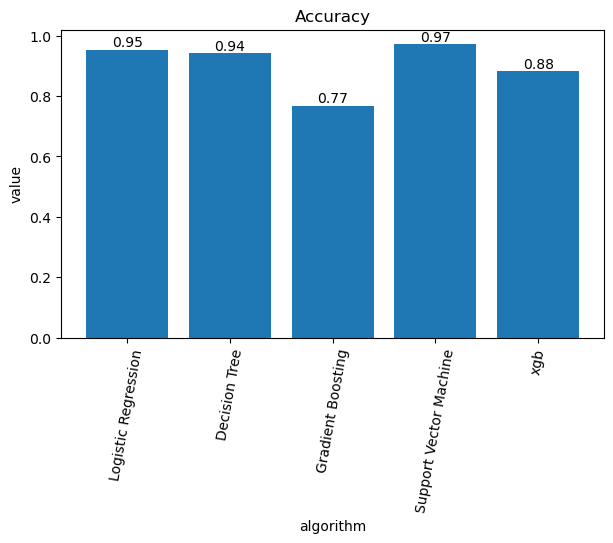

In [51]:
fig, ax = plt.subplots(figsize =(7, 4))
bars = ax.bar(xaxis, yaxis)
# for i in ax.patches:
#     plt.text(i.get_width()+0.02, i.get_y()+0.3, 
#              str(round((i.get_width()), 4)),
#              fontsize = 10, fontweight ='bold',
#              color ='grey')

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')
plt.xlabel('algorithm')
plt.ylabel('value')
plt.title('Accuracy')

# Rotating x-axis labels for better visibility
plt.xticks(rotation=80)

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(base_cnn_model, to_file='base_cnn_model.png')